# NBA 2023-24 Regular Season Standings & Playoff Matchup Predictor



### Team SSS - Andrew Grant, Anthony Matricia, & Haris Jilani

## Introduction

The project we plan to tackle is to determine the most important statistics that result in success in the NBA regular season and playoffs. Using the key playoff statitistics in which the 2022-23 NBA Champions Denver Nuggets were ranked high, we aim to predict the 2023-24 NBA regular season standings (the winning percentage of each team) and compare them to the actual results. In addition, we want to predict the 2023-24 NBA playoffs (who wins in each matchup) and compare our predictions to the actual results.

## Dataset

The dataset we chose is a combination of a couple different subsections of statistics we found on basketball reference. The first two links serve to provide us with the 2023-24 NBA regular season and 2022-23 NBA playoff stats that will allow us to predict the 2023-24 NBA regular season rankings and the winners of the 2023-24 NBA playoff matchups. Each of the datasets are currently linked as an url and read using the read_html Pandas method. The first url is the NBA standings, which is used to differentiate the 32 teams into their respective conferences. The second url consists of per game stats for all the 32 NBA teams during the 2023-24 NBA season. The third url is the 2023-24 season playoff stats for each of the 16 teams that participated in the playoffs. Using the features/statistics in which the playoff winners were ranked high, we can analyze the data and use it to train a model to predict the current 2023-24 NBA playoffs. The last two links are advanced statistics from the past 2 NBA regular seasons, where we can create and choose certain predictors that may not be available in regular per game statistics.

In [291]:
#%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from collections import OrderedDict

sns.set()
rcParams['figure.figsize'] = 8,6
sns.set_context('talk')   # 'talk' for slightly larger

pd.set_option('display.max_columns', 500)

url_2024_regular = 'https://www.basketball-reference.com/leagues/NBA_2024.html#per_game-team'
url_2024_playoffs = 'https://www.basketball-reference.com/playoffs/NBA_2024.html#per_game-team'
advanced_team_2024 = 'https://www.basketball-reference.com/leagues/NBA_2024.html#advanced-team'
advanced_team_2023 = 'https://www.basketball-reference.com/playoffs/NBA_2024.html#advanced-team'

## Data Preprocessing

In [292]:
# reads in a list of tables/dataframes
standings_2024_regular = pd.read_html(url_2024_regular, match='Conference Standings')
stats_2024_regular = pd.read_html(url_2024_regular, match='Per Game Stats')
stats_2024_playoffs = pd.read_html(url_2024_playoffs, match='Per Game Stats')
adv_stats_2024 = pd.read_html(advanced_team_2024, match='Advanced Stats')
adv_stats_2024_playoffs = pd.read_html(advanced_team_2023, match='Advanced Stats')

In [293]:
# prints the columns for each table read
print("Columns for...")
print()
print("2023-24 Regular Season Standings: ")
print(standings_2024_regular[0]['Eastern Conference'])
print("2023-24 Regular Season Per Game Team Stats: ")
print(stats_2024_regular[0].columns)
print()
print("2022-23 Playoffs Per Game Team Stats: ")
print(stats_2024_playoffs[0].columns)
print()
print("2023-24 Regular Season Advanced Team Stats: ")
print(adv_stats_2024[0].columns)
print()
print("2023-24 Playoffs Advanced Team Stats: ")
print(adv_stats_2024_playoffs[0].columns)

Columns for...

2023-24 Regular Season Standings: 
0          Boston Celtics* (1)
1         New York Knicks* (2)
2         Milwaukee Bucks* (3)
3     Cleveland Cavaliers* (4)
4           Orlando Magic* (5)
5          Indiana Pacers* (6)
6      Philadelphia 76ers* (7)
7              Miami Heat* (8)
8            Chicago Bulls (9)
9           Atlanta Hawks (10)
10          Brooklyn Nets (11)
11        Toronto Raptors (12)
12      Charlotte Hornets (13)
13     Washington Wizards (14)
14        Detroit Pistons (15)
Name: Eastern Conference, dtype: object
2023-24 Regular Season Per Game Team Stats: 
Index(['Rk', 'Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

2022-23 Playoffs Per Game Team Stats: 
Index(['Rk', 'Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', '

In [296]:
#Columns initially returned as two-part tuples
#We just want the second part of the tuple with the stat category name
cols = []
for col in adv_stats_2024[0].columns:
  cols.append(col[1])
adv_stats_2024[0].columns = cols

cols = []
for col in adv_stats_2024_playoffs[0].columns:
  cols.append(col[1])
adv_stats_2024_playoffs[0].columns = cols

In [297]:
# Some columns can be dropped due to formatting from original table; some rows are unneeded.
drop_cols_2024 = ['Unnamed: 17_level_1', 'Unnamed: 22_level_1', 'Unnamed: 27_level_1', 'Arena', 'Attend.', 'Attend./G', 'PW', 'PL']
drop_cols_2023 = ['Unnamed: 15_level_1', 'Unnamed: 20_level_1', 'PW', 'PL']

stats_2024_regular[0].drop(30, inplace=True)
stats_2024_playoffs[0].drop(16, inplace=True)
adv_stats_2024[0].drop(columns = drop_cols_2024, inplace=True)
adv_stats_2024[0].drop(30, inplace=True)
adv_stats_2024_playoffs[0].drop(columns = drop_cols_2023, inplace=True)
adv_stats_2024_playoffs[0].drop(16, inplace=True)

print("2023-24 Regular Season Per Game Team Stats: ")
print(stats_2024_regular[0].columns)
print()
print("2023-24 Playoffs Per Game Team Stats: ")
print(stats_2024_playoffs[0].columns)
print()
print("2023-24 Regular Season Advanced Team Stats: ")
print(adv_stats_2024[0].columns)
print()
print("2023-24 Playoffs Advanced Team Stats: ")
print(adv_stats_2024_playoffs[0].columns)

2023-24 Regular Season Per Game Team Stats: 
Index(['Rk', 'Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

2023-24 Playoffs Per Game Team Stats: 
Index(['Rk', 'Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

2023-24 Regular Season Advanced Team Stats: 
Index(['Rk', 'Team', 'Age', 'W', 'L', 'MOV', 'SOS', 'SRS', 'ORtg', 'DRtg',
       'NRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA',
       'eFG%', 'TOV%', 'DRB%', 'FT/FGA'],
      dtype='object')

2023-24 Playoffs Advanced Team Stats: 
Index(['Rk', 'Team', 'Age', 'W', 'L', 'W/L%', 'ORtg', 'DRtg', 'NRtg', 'Pace',
       'FTr', '3PAr', 'TS%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'eFG%', 'TOV%',
       'DRB%', 'FT/FGA'],
      

In [298]:
# Create column for Win%
adv_stats_2024[0]['Win%'] = adv_stats_2024[0]['W']/82

In [299]:
# Removing asterisk in team names that signifies making the playoffs but is not relevant here
standings_2024_regular[0]['Eastern Conference'] = standings_2024_regular[0]['Eastern Conference'].str.replace('*', '')
for i in range(16):
  standings_2024_regular[0]['Eastern Conference'] = standings_2024_regular[0]['Eastern Conference'].str.replace('({})'.format(i), '')
standings_2024_regular[0]['Eastern Conference'] = standings_2024_regular[0]['Eastern Conference'].str.replace('\xa0', '')
stats_2024_regular[0]['Team'] = stats_2024_regular[0]['Team'].str.replace('*', '')
stats_2024_playoffs[0]['Team'] = stats_2024_playoffs[0]['Team'].str.replace('*', '')
adv_stats_2024[0]['Team'] = adv_stats_2024[0]['Team'].str.replace('*', '')
adv_stats_2024_playoffs[0]['Team'] = adv_stats_2024_playoffs[0]['Team'].str.replace('*', '')
eastern_conf_teams = standings_2024_regular[0]['Eastern Conference'].values

In [300]:
#Removing column Rank and setting index to Team
stats_2024_regular[0].drop(columns = 'Rk', inplace=True)
stats_2024_regular[0].set_index('Team', inplace=True)

stats_2024_playoffs[0].drop(columns = 'Rk', inplace=True)
stats_2024_playoffs[0].set_index('Team', inplace=True)

adv_stats_2024_playoffs[0].drop(columns = 'Rk', inplace=True)
adv_stats_2024_playoffs[0].set_index('Team', inplace=True)

adv_stats_2024[0].drop(columns = 'Rk', inplace=True)
adv_stats_2024[0].set_index('Team', inplace=True)

In [301]:
#Original table has eFG%, TOV%, ORB%, and FT/FGA for both team and opponents
#This will remove the opponent versions
adv_stats_2024[0] = adv_stats_2024[0].loc[:,~adv_stats_2024[0].columns.duplicated()].copy()

In [302]:
#Combining the two pairs of dataframes of per game and advanced stats into two dataframes
per_team_regular = pd.concat([stats_2024_regular[0], adv_stats_2024[0]], axis=1, join='outer')
per_team_playoffs = pd.concat([stats_2024_playoffs[0], adv_stats_2024_playoffs[0]], axis=1, join='outer')
playoff_teams = per_team_playoffs.index
playoff_team_stats = pd.concat([per_team_regular.loc[playoff_teams].rename(columns=lambda x: 'r' + x), per_team_playoffs.rename(columns=lambda x: 'p' + x)], axis=1, join='outer')
print(playoff_team_stats.columns)

Index(['rG', 'rMP', 'rFG', 'rFGA', 'rFG%', 'r3P', 'r3PA', 'r3P%', 'r2P',
       'r2PA', 'r2P%', 'rFT', 'rFTA', 'rFT%', 'rORB', 'rDRB', 'rTRB', 'rAST',
       'rSTL', 'rBLK', 'rTOV', 'rPF', 'rPTS', 'rAge', 'rW', 'rL', 'rMOV',
       'rSOS', 'rSRS', 'rORtg', 'rDRtg', 'rNRtg', 'rPace', 'rFTr', 'r3PAr',
       'rTS%', 'reFG%', 'rTOV%', 'rORB%', 'rFT/FGA', 'rDRB%', 'rWin%', 'pG',
       'pMP', 'pFG', 'pFGA', 'pFG%', 'p3P', 'p3PA', 'p3P%', 'p2P', 'p2PA',
       'p2P%', 'pFT', 'pFTA', 'pFT%', 'pORB', 'pDRB', 'pTRB', 'pAST', 'pSTL',
       'pBLK', 'pTOV', 'pPF', 'pPTS', 'pAge', 'pW', 'pL', 'pW/L%', 'pORtg',
       'pDRtg', 'pNRtg', 'pPace', 'pFTr', 'p3PAr', 'pTS%', 'peFG%', 'pTOV%',
       'pORB%', 'pFT/FGA', 'peFG%', 'pTOV%', 'pDRB%', 'pFT/FGA'],
      dtype='object')


## Data Exploration & Visualizations

In [303]:
# Check the correlation between 'Win%' and the other columns.
per_team_regular.corr()['Win%'].sort_values(ascending=False)

W         1.000000
Win%      1.000000
SRS       0.981739
MOV       0.981206
NRtg      0.979684
ORtg      0.863254
3P%       0.855850
TS%       0.803252
eFG%      0.773119
FG%       0.685370
PTS       0.612089
2P%       0.609569
DRB       0.566749
Age       0.552988
FG        0.464400
3P        0.444940
FT/FGA    0.352415
FTr       0.345795
TRB       0.334718
FT        0.333783
DRB%      0.318385
FTA       0.315377
BLK       0.237157
STL       0.231162
3PAr      0.201027
FT%       0.170089
AST       0.157206
2P        0.153185
3PA       0.119695
ORB%      0.058135
MP       -0.100437
ORB      -0.192842
FGA      -0.225429
PF       -0.283647
2PA      -0.320166
Pace     -0.330305
SOS      -0.451591
TOV%     -0.514321
TOV      -0.596476
DRtg     -0.751010
L        -1.000000
G              NaN
Name: Win%, dtype: float64

<Axes: xlabel='NRtg', ylabel='Win%'>

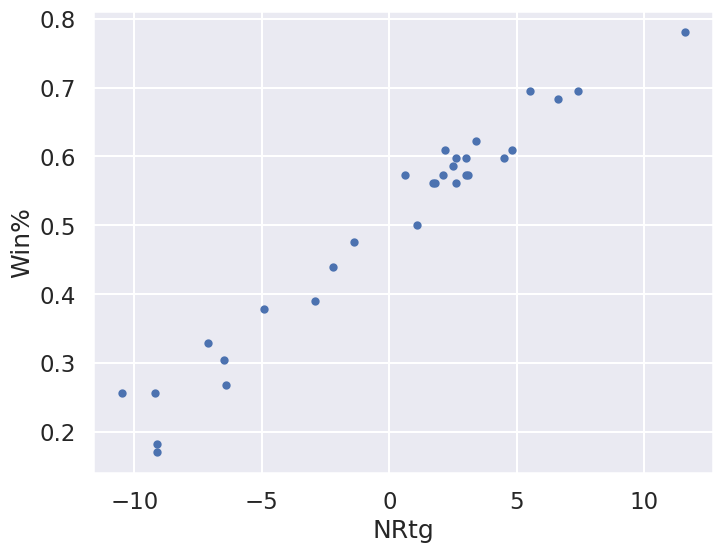

In [304]:
# Plot the highly correlated 'NRtg' with the 'Win%' and analyze their relationship.
per_team_regular.plot.scatter(x='NRtg', y='Win%')

In [305]:
#Note: 2023 Denver Nuggets were Top 3 in Offensive Rating, Defensive Rating, Net Rating, True Shooting Percentage, and Effective Field Goal Percentage
print(per_team_regular.iloc[:, [29, 30, 31, 36]])

                         ORtg   DRtg  NRtg   eFG%
Team                                             
Indiana Pacers          121.0  118.0   3.0  0.578
Boston Celtics          123.2  111.6  11.6  0.578
Oklahoma City Thunder   119.5  112.1   7.4  0.573
Milwaukee Bucks         118.4  115.8   2.6  0.568
Atlanta Hawks           117.2  119.4  -2.2  0.539
Los Angeles Lakers      115.9  115.3   0.6  0.566
Dallas Mavericks        117.6  115.4   2.2  0.562
Golden State Warriors   117.8  115.2   2.6  0.557
Sacramento Kings        116.9  115.2   1.7  0.556
Phoenix Suns            117.6  114.6   3.0  0.565
Utah Jazz               115.5  120.4  -4.9  0.539
Los Angeles Clippers    118.8  115.4   3.4  0.561
New Orleans Pelicans    117.4  112.9   4.5  0.558
Denver Nuggets          118.5  113.0   5.5  0.562
Philadelphia 76ers      116.9  113.8   3.1  0.532
Houston Rockets         114.5  113.4   1.1  0.529
Washington Wizards      110.5  119.6  -9.1  0.538
Minnesota Timberwolves  115.6  109.0   6.6  0.559


## Machine Learning

#### Predictors & Target Variables

The predictors we chose were based on the team statistics in which the 2022-23 NBA Champions Denver Nuggets ranked in the top three during their playoff run: field goal percentage, 3 point percentage, 2 point percentage, number of defensive rebounds, number of assists, offensive rating, defensive rating, net rating, and efficient field goal percentage. Using these statistics, we want to predict the winning percentage if each team in the 2023-24 NBA regular season, which is our target variable. Ultimately, the sorted predicted values in decreasing order will provide us with the predicted 2023-24 NBA regular season rankings. Using the same predictor and target variables, we will predict the 2022-23 NBA playoffs.

In [306]:
predictors = ['FG%', '3P%', '2P%', 'DRB', 'AST', 'ORtg', 'DRtg', 'NRtg', 'eFG%']
target = 'Win%'
X = per_team_regular[predictors].values
y = per_team_regular[target].values

#### Train & Test Data

In [307]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Baseline Performance

In [308]:
y_test_mean = np.full(y_test.shape, np.mean(y_train))
print('Test RMSE Baseline: {:0.2f}'.format(np.sqrt(((y_test_mean - y_test)**2).mean())))

Test RMSE Baseline: 0.14


#### Linear Regression Model for Regular Season Standings (With Training)

Training MSE: 0.0009
Test MSE: 0.0011
Training RMSE: 0.0297
Test RMSE: 0.0333
Training R^2: 0.9681
Test R^2: 0.9377


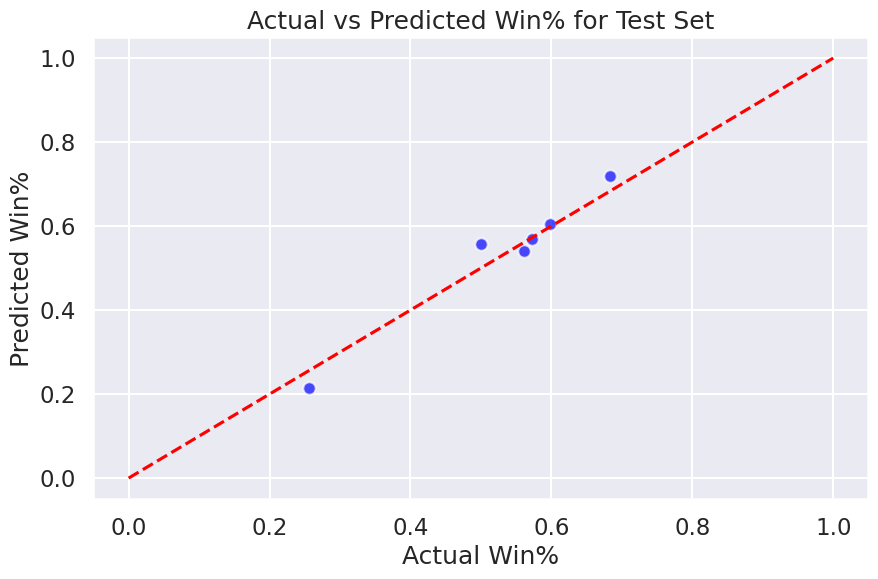

In [309]:
#create + train model
model = LinearRegression()
model.fit(X_train, y_train)

#predict
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#eval
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

#output
print(f'Training MSE: {mse_train:.4f}')
print(f'Test MSE: {mse_test:.4f}')
print(f'Training RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')
print(f'Training R^2: {r2_train:.4f}')
print(f'Test R^2: {r2_test:.4f}')

#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', edgecolor='w', alpha=0.7)
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('Actual Win%')
plt.ylabel('Predicted Win%')
plt.title('Actual vs Predicted Win% for Test Set')
plt.show()

In [310]:
#y-intercept + coefficients
print('Intercept: {:0.2f}'.format(model.intercept_))
for i in range(len(predictors)):
  print('{}: {:0.2f}'.format(predictors[i], model.coef_[i]))

Intercept: 0.48
FG%: 0.02
3P%: 0.16
2P%: 0.29
DRB: 0.00
AST: -0.01
ORtg: -6197448497722.12
DRtg: 3947479331629.72
NRtg: 8589448911783.86
eFG%: -0.43


#### Linear Regression Model for Regular Season Standings (Without Training)

MSE: 0.0008
RMSE: 0.0287
R^2: 0.9681


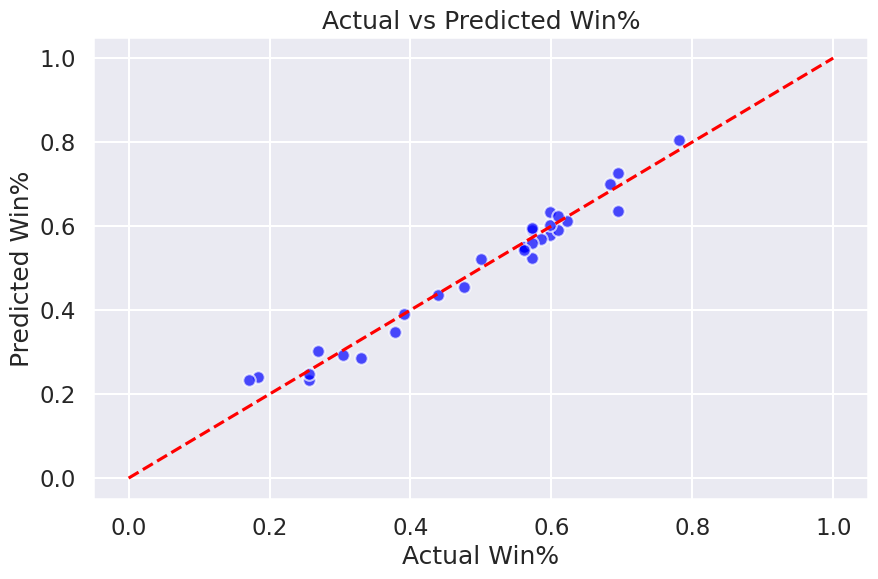

In [311]:
#create + train model
model2 = LinearRegression()
model2.fit(X, y)

#predict
y_pred = model2.predict(X)

#eval
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

#output
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R^2: {r2:.4f}')

#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', edgecolor='w', alpha=0.7)
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('Actual Win%')
plt.ylabel('Predicted Win%')
plt.title('Actual vs Predicted Win%')
plt.show()

In [312]:
#y-intercept + coefficients
print('Intercept: {:0.2f}'.format(model2.intercept_))
for i in range(len(predictors)):
  print('{}: {:0.2f}'.format(predictors[i], model2.coef_[i]))

Intercept: 0.59
FG%: 0.13
3P%: 15.30
2P%: 15.88
DRB: -0.00
AST: -0.00
ORtg: -87722251795.95
DRtg: 87722251795.95
NRtg: 87722251795.98
eFG%: -25.47


#### Predicted 2023-24 NBA Regular Standings

In [313]:
# new dataframe with every team and their actual vs predicted win %
standings = pd.DataFrame({'Actual Win%': y, 'Predicted Win%': y_pred}, index=per_team_regular.index)

# sort standings
true_standings = standings.sort_values(by='Predicted Win%', ascending=False)

# Split into east and west.
east_team = []
west_team = []
east_win_perc = []
west_win_perc = []
for team in true_standings.index:
  if team in eastern_conf_teams:
     east_team.append(team)
     east_win_perc.append(true_standings['Predicted Win%'][team])
  else:
    west_team.append(team)
    west_win_perc.append(true_standings['Predicted Win%'][team])

# New dataframes for Eastern Conference standings and Western Conference Standings.
east_standings = pd.DataFrame({'Win%': east_win_perc}, index=east_team)
west_standings = pd.DataFrame({'Win%': west_win_perc}, index=west_team)

# Output the two standings
print("2023-24 Eastern Conference Predicted Standings")
print(east_standings)
print()
print("2023-24 Western Conference Predicted Standings")
print(west_standings)


2023-24 Eastern Conference Predicted Standings
                         Win%
Boston Celtics       0.805915
New York Knicks      0.623783
Philadelphia 76ers   0.596212
Indiana Pacers       0.591666
Milwaukee Bucks      0.578675
Cleveland Cavaliers  0.569852
Orlando Magic        0.560341
Miami Heat           0.544159
Chicago Bulls        0.454496
Atlanta Hawks        0.436468
Brooklyn Nets        0.390433
Toronto Raptors      0.292690
Washington Wizards   0.240066
Charlotte Hornets    0.234244
Detroit Pistons      0.232890

2023-24 Western Conference Predicted Standings
                            Win%
Oklahoma City Thunder   0.726640
Minnesota Timberwolves  0.699104
Denver Nuggets          0.636683
New Orleans Pelicans    0.633546
Los Angeles Clippers    0.611972
Phoenix Suns            0.602971
Dallas Mavericks        0.589579
Sacramento Kings        0.549417
Golden State Warriors   0.548777
Los Angeles Lakers      0.524171
Houston Rockets         0.522733
Utah Jazz               0.347

#### Prediction Functions for 2023-24 NBA Playoff Predictions

In [315]:
# 16 playoff teams, splits them to their correct conference (Eastern and Western)
def split_into_east_west(teams, pred):
  for i in range(16):
    if playoff_teams[i] in east_standings.index:
      east_playoff_teams.append(teams[i])
      east_playoff_pred.append(pred[i])
    else:
      west_playoff_teams.append(teams[i])
      west_playoff_pred.append(pred[i])

# Predicts the NBA championship
def predict_finals(team1, team2):
  win_percentage1 = team1['Predicted Win%']
  win_percentage2 = team2['Predicted Win%']
  return team1['Team'] if win_percentage1 > win_percentage2 else team2['Team']

# Predicts the entire playoffs (all the winners in each conference including the NBA champion)
def predict_playoffs(east, west):
  #example matchup predictions based on standard seeding (highest seeded team vs lowest seeded team)
  east.sort_values(by='Predicted Win%', ascending=False, inplace=True)
  west.sort_values(by='Predicted Win%', ascending=False, inplace=True)

  print("East first round winners: {}".format(east[0:4]['Team'].values))
  print("West first round winners: {}".format(west[0:4]['Team'].values))
  print()

  # Semifinals Winners
  print("Eastern Semifinals winners: {}".format(east[0:2]['Team'].values))
  print("Western Semifinals winners: {}".format(west[0:2]['Team'].values))
  print()

  # Conference Finals Winners
  print("Eastern Conference Finals winners: {}".format(east['Team'].values[0]))
  print("Western Conference Finals winners: {}".format(west['Team'].values[0]))
  print()

  # NBA Champion
  champion = predict_finals(east.iloc[0], west.iloc[0])
  print("The NBA Champion is: {}".format(champion))

#### Linear Regression Model for Playoffs (With Training Data)

Training MSE: 0.0098
Test MSE: 0.7010
Training RMSE: 0.0992
Test RMSE: 0.8373
Training R^2: 0.7597
Test R^2: -10.8127



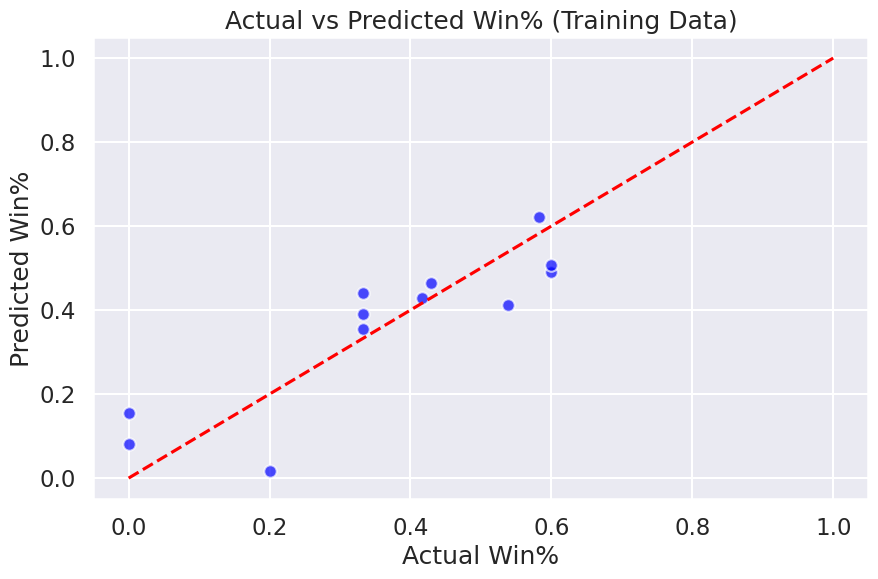

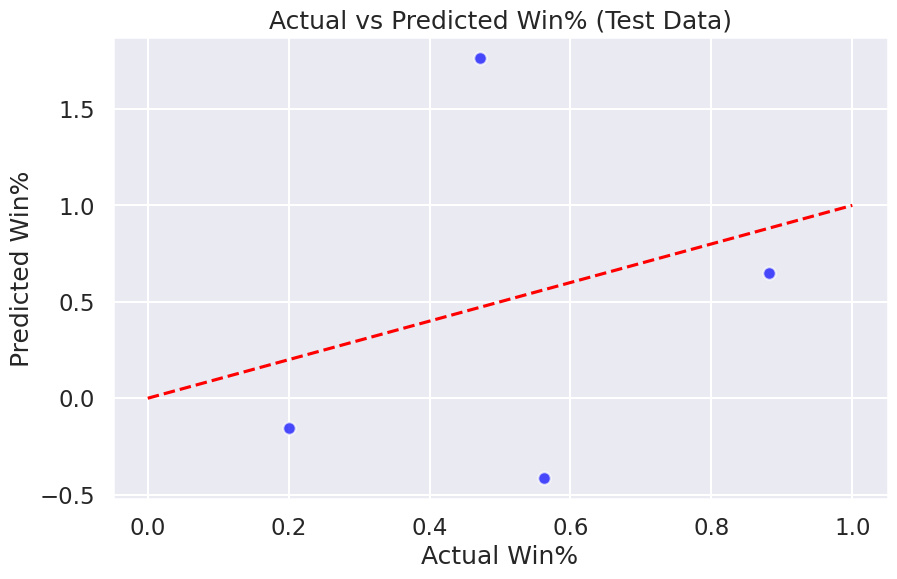

Intercept: 0.52
rFG%: -0.09
r3P%: -0.94
r2P%: -1.10
rDRB: -0.21
rAST: 0.08
rORtg: 7186776062964.23
rDRtg: -6174117016887.14
rNRtg: -7585735124184.00
reFG%: 1.80


In [316]:
#use model to predict playoff teams' win%
predictors = ['rFG%', 'r3P%', 'r2P%', 'rDRB', 'rAST', 'rORtg', 'rDRtg', 'rNRtg', 'reFG%']
target = 'pW/L%'
X = playoff_team_stats[predictors].values
y = playoff_team_stats[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model3 = LinearRegression()
model3.fit(X_train, y_train)

#predict
y_pred_train = model3.predict(X_train)
y_pred_test = model3.predict(X_test)

# #eval
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# #output
print(f'Training MSE: {mse_train:.4f}')
print(f'Test MSE: {mse_test:.4f}')
print(f'Training RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')
print(f'Training R^2: {r2_train:.4f}')
print(f'Test R^2: {r2_test:.4f}')
print()

#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, color='blue', edgecolor='w', alpha=0.7)
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('Actual Win%')
plt.ylabel('Predicted Win%')
plt.title('Actual vs Predicted Win% (Training Data)')
plt.show()

#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', edgecolor='w', alpha=0.7)
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('Actual Win%')
plt.ylabel('Predicted Win%')
plt.title('Actual vs Predicted Win% (Test Data)')
plt.show()

#y-intercept + coefficients
print('Intercept: {:0.2f}'.format(model3.intercept_))
for i in range(len(predictors)):
  print('{}: {:0.2f}'.format(predictors[i], model3.coef_[i]))

Since our test RMSE is poor, let's find the 9 best features out of the 83 features (excluding the win percentage) in the dataframe that will give us the better test RMSE.

In [317]:
playoff_team_stats_copy = playoff_team_stats.copy()
playoff_team_stats_copy.drop(columns='pW/L%', inplace=True)
X = playoff_team_stats_copy.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model4 = LinearRegression()
model4.fit(X_train, y_train)

print(X_train.shape[1])
remaining = list(range(X_train.shape[1]))
selected = []
while len(selected) < 9:
    rmse_min = 1e7
    for i in remaining:
      if len(selected) == 0:
        scores = cross_val_score(LinearRegression(), X_train[:, [i]], y_train, scoring='neg_mean_squared_error', cv=5)
      if len(selected) > 0:
          index = []
          index.extend(selected)
          index.append(i)
          scores = cross_val_score(LinearRegression(), X_train[:, index], y_train, scoring='neg_mean_squared_error', cv=5)
      rmse = np.sqrt(-scores.mean())
      if rmse <= rmse_min:
          rmse_min = rmse
          i_min = i
    remaining.remove(i_min)
    selected.append(i_min)
    print('num features: {}; rmse: {:.4f}'.format(len(selected), rmse_min))
    # print("The features: {}".format(playoff_team_stats.iloc[selected]))
    print()

83
num features: 1; rmse: 0.1518

num features: 2; rmse: 0.0699

num features: 3; rmse: 0.0539

num features: 4; rmse: 0.0385

num features: 5; rmse: 0.0375

num features: 6; rmse: 0.0375

num features: 7; rmse: 0.0391

num features: 8; rmse: 0.0385

num features: 9; rmse: 0.0219



The RMSE peaks at the 9 best features selected. Let's use those 9 features to fit our new model and see how it compares with our original RMSE.


Test MSE: 0.0220
Test RMSE: 0.1482
Test R^2: 0.6300


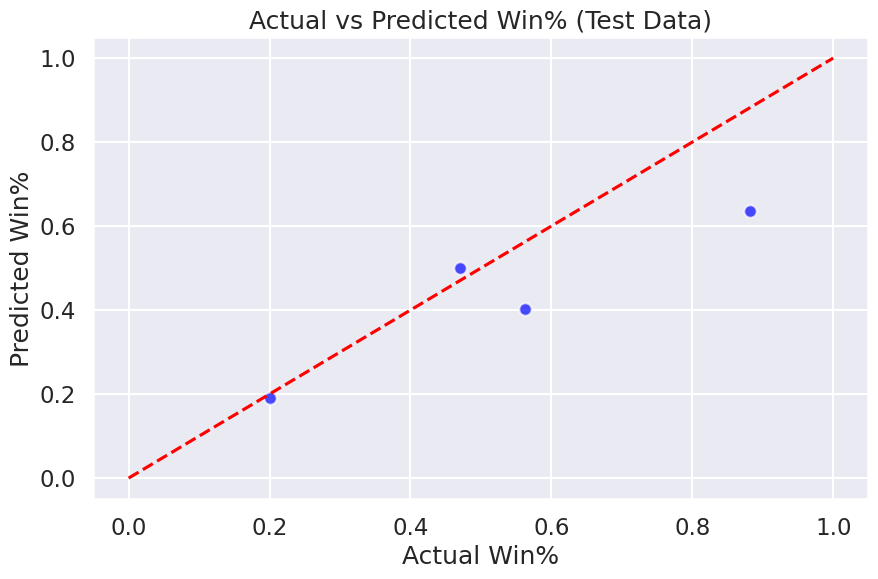

Intercept: 0.36
rFG%: 0.13
r3P%: -0.16
r2P%: 0.14
rDRB: -0.08
rAST: -0.06
rORtg: 0.00
rDRtg: 0.06
rNRtg: -0.06
reFG%: -0.04


In [318]:
model4 = LinearRegression()
best_features = selected[0:10]
model4.fit(X_train[:, best_features], y_train)

y_pred_test = model4.predict(X_test[:, best_features])

#eval
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

#output
print(f'Test MSE: {mse_test:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')
print(f'Test R^2: {r2_test:.4f}')

#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', edgecolor='w', alpha=0.7)
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('Actual Win%')
plt.ylabel('Predicted Win%')
plt.title('Actual vs Predicted Win% (Test Data)')
plt.show()

#y-intercept + coefficients
print('Intercept: {:0.2f}'.format(model4.intercept_))
for i in range(len(predictors)):
  print('{}: {:0.2f}'.format(predictors[i], model4.coef_[i]))

#### Linear Regression Model for Playoffs (Without Training Data)

MSE: 0.0375
RMSE: 0.1938
Test R^2: 0.2589



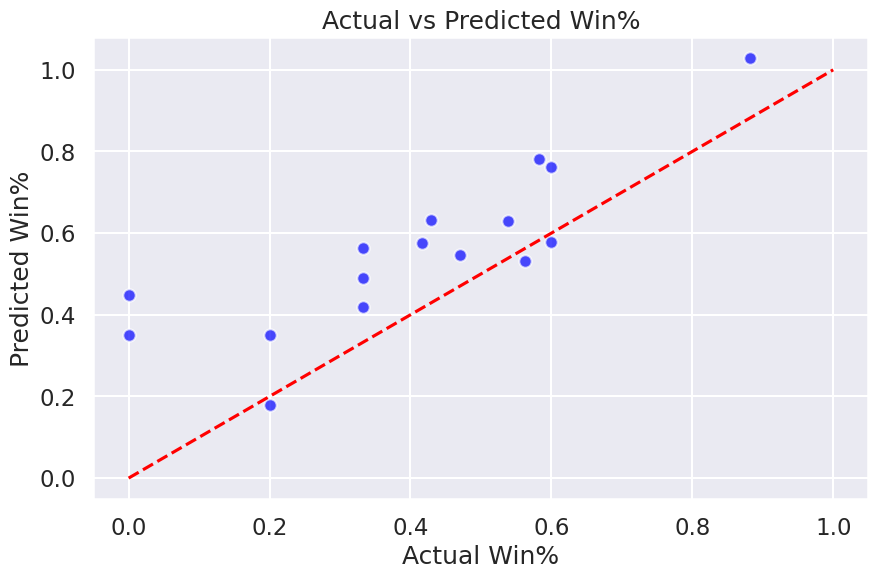

Intercept: 0.52
rFG%: -0.09
r3P%: -0.94
r2P%: -1.10
rDRB: -0.21
rAST: 0.08
rORtg: 7186776062964.23
rDRtg: -6174117016887.14
rNRtg: -7585735124184.00
reFG%: 1.80


In [319]:
#use model to predict playoff teams' win%
predictors = ['rFG%', 'r3P%', 'r2P%', 'rDRB', 'rAST', 'rORtg', 'rDRtg', 'rNRtg', 'reFG%']
target = 'pW/L%'
X = playoff_team_stats[predictors].values
y = playoff_team_stats[target].values
model5 = LinearRegression()
model5.fit(X, y)

playoff_predictions = model5.predict(X)

#eval
mse = mean_squared_error(y, playoff_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y, playoff_predictions)

#output
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'Test R^2: {r2:.4f}')
print()

#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y, playoff_predictions, color='blue', edgecolor='w', alpha=0.7)
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('Actual Win%')
plt.ylabel('Predicted Win%')
plt.title('Actual vs Predicted Win%')
plt.show()

#y-intercept + coefficients
print('Intercept: {:0.2f}'.format(model3.intercept_))
for i in range(len(predictors)):
  print('{}: {:0.2f}'.format(predictors[i], model3.coef_[i]))

#### Predicted 2023-24 NBA Playoffs (Linear Regression)

In [320]:
east_playoff_teams = []
east_playoff_pred = []
west_playoff_teams = []
west_playoff_pred = []

split_into_east_west(playoff_teams, playoff_predictions)

#dataframes
east_predictions_df = pd.DataFrame({
    'Team': east_playoff_teams,
    'Predicted Win%': east_playoff_pred
})
west_predictions_df = pd.DataFrame({
    'Team': west_playoff_teams,
    'Predicted Win%': west_playoff_pred
})

predict_playoffs(east_predictions_df, west_predictions_df)

East first round winners: ['Boston Celtics' 'Orlando Magic' 'New York Knicks' 'Cleveland Cavaliers']
West first round winners: ['Denver Nuggets' 'Dallas Mavericks' 'Oklahoma City Thunder'
 'Minnesota Timberwolves']

Eastern Semifinals winners: ['Boston Celtics' 'Orlando Magic']
Western Semifinals winners: ['Denver Nuggets' 'Dallas Mavericks']

Eastern Conference Finals winners: Boston Celtics
Western Conference Finals winners: Denver Nuggets

The NBA Champion is: Boston Celtics


#### Random Forest Regression Model for Playoffs (With Training Data)

Training MSE: 0.0074
Test MSE: 0.1262
Training RMSE: 0.0859
Test RMSE: 0.3552
Training R^2: 0.8199
Test R^2: -1.1262



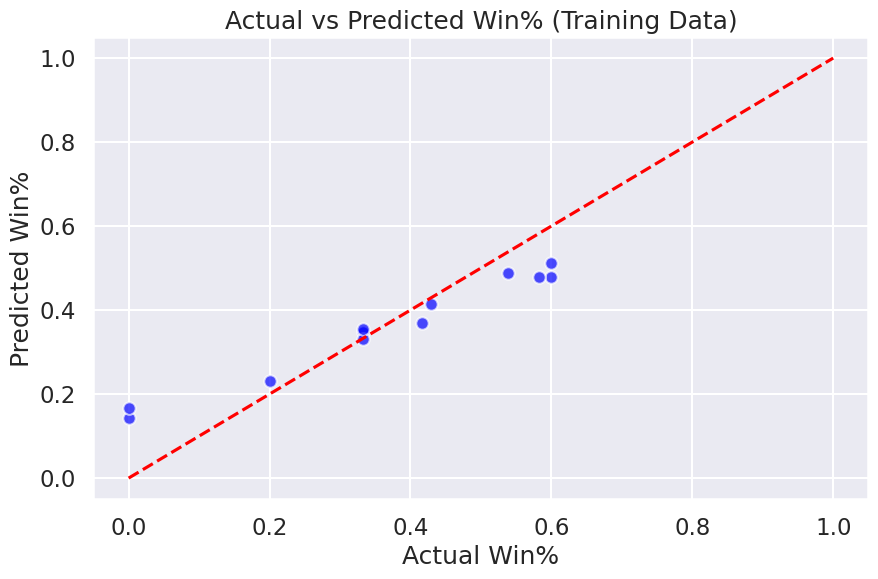

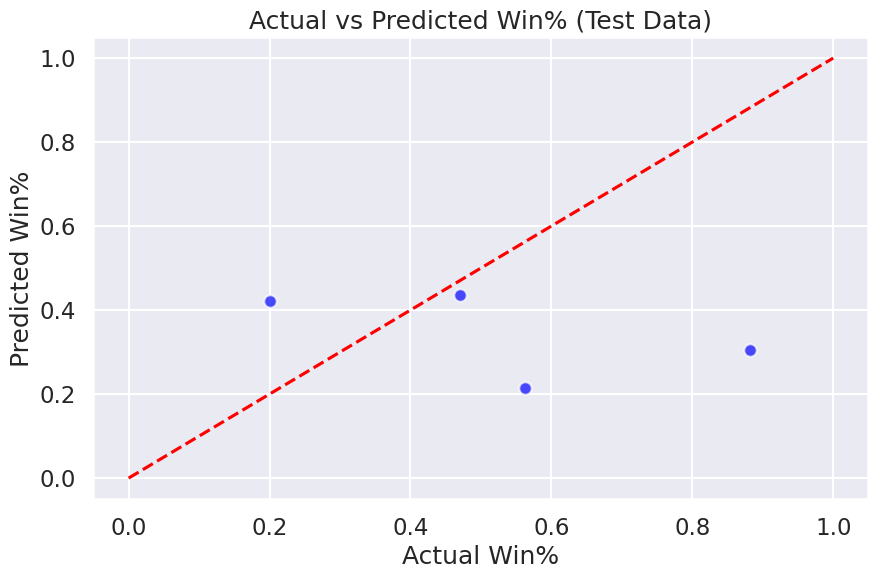

In [321]:
#train an rfr model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
X = playoff_team_stats[predictors].values
y = playoff_team_stats[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
rf_model.fit(X_train, y_train)

#predict
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# #eval
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
rmse_test_rf = np.sqrt(mse_test_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)

# #output
print(f'Training MSE: {mse_train_rf:.4f}')
print(f'Test MSE: {mse_test_rf:.4f}')
print(f'Training RMSE: {rmse_train_rf:.4f}')
print(f'Test RMSE: {rmse_test_rf:.4f}')
print(f'Training R^2: {r2_train_rf:.4f}')
print(f'Test R^2: {r2_test_rf:.4f}')
print()

#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train_rf, color='blue', edgecolor='w', alpha=0.7)
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('Actual Win%')
plt.ylabel('Predicted Win%')
plt.title('Actual vs Predicted Win% (Training Data)')
plt.show()

#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_rf, color='blue', edgecolor='w', alpha=0.7)
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('Actual Win%')
plt.ylabel('Predicted Win%')
plt.title('Actual vs Predicted Win% (Test Data)')
plt.show()

In [322]:
remaining = list(range(X_train.shape[1]))
selected = []
rmse_mins = []
while len(selected) < 9:
    rmse_min = 1e7
    for i in remaining:
      if len(selected) == 0:
        scores = cross_val_score(rf_model, X_train[:, [i]], y_train, scoring='neg_mean_squared_error', cv=5)
      if len(selected) > 0:
          index = []
          index.extend(selected)
          index.append(i)
          scores = cross_val_score(rf_model, X_train[:, index], y_train, scoring='neg_mean_squared_error', cv=5)
      rmse = np.sqrt(-scores.mean())
      if rmse <= rmse_min:
          rmse_min = rmse
          rmse_mins.append(rmse_min)
          i_min = i
    remaining.remove(i_min)
    selected.append(i_min)
    print('num features: {}; rmse: {:.2f}'.format(len(selected), rmse_min))

num features: 1; rmse: 0.20
num features: 2; rmse: 0.23
num features: 3; rmse: 0.25
num features: 4; rmse: 0.26
num features: 5; rmse: 0.26
num features: 6; rmse: 0.26
num features: 7; rmse: 0.26
num features: 8; rmse: 0.27
num features: 9; rmse: 0.27


The RMSE peaks at the the very first feature, hence let's use that feature to fit our model.


Test MSE: 0.0962
Test RMSE: 0.3101
Test R^2: -0.6207


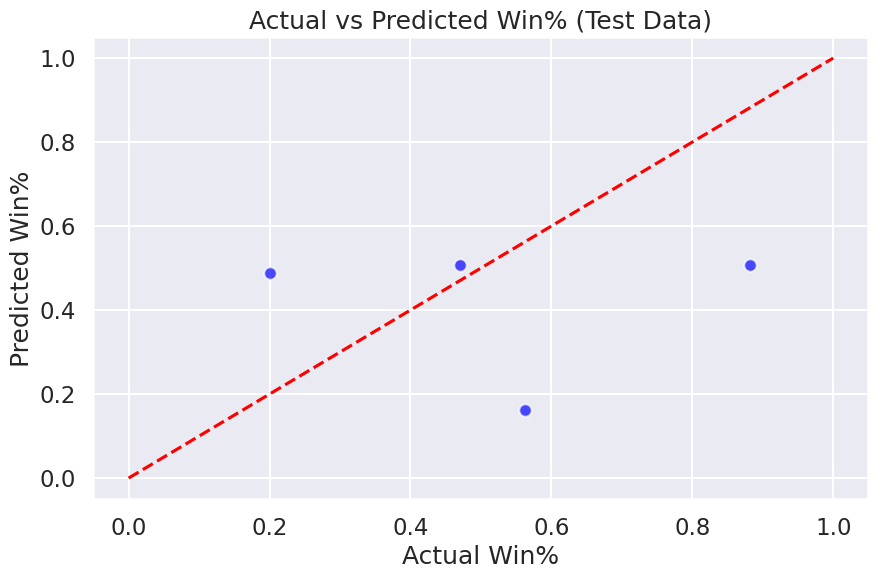

In [323]:
rf_best = RandomForestRegressor(n_estimators=100, random_state=42)
best_feature = selected[0]
rf_best.fit(X_train[:, [best_feature]], y_train)

y_pred_test = rf_best.predict(X_test[:, [best_feature]])

#eval
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

#output
print(f'Test MSE: {mse_test:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')
print(f'Test R^2: {r2_test:.4f}')

#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', edgecolor='w', alpha=0.7)
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('Actual Win%')
plt.ylabel('Predicted Win%')
plt.title('Actual vs Predicted Win% (Test Data)')
plt.show()

#### Random Forest Regression Model for Playoffs (Without Training Data)


MSE: 0.0083
RMSE: 0.0913
Test R^2: 0.8353



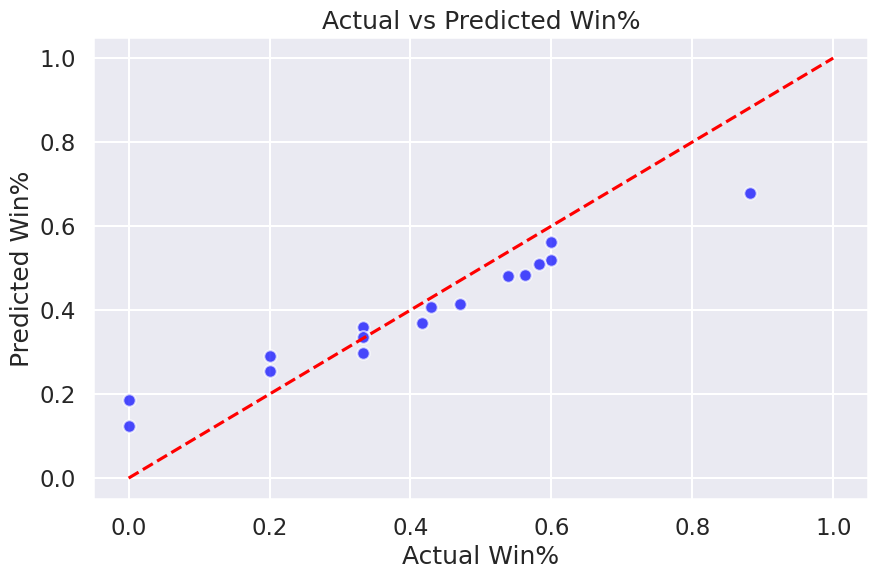

In [324]:
# Fit the same model with values instead of training data.
rf_model.fit(X, y)

#use rfr model for playoff predicts
playoff_predictions_rf = rf_model.predict(X)
print()

#eval
mse = mean_squared_error(y, playoff_predictions_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y, playoff_predictions_rf)

#output
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'Test R^2: {r2:.4f}')
print()

east_playoff_teams = []
east_playoff_pred = []
west_playoff_teams = []
west_playoff_pred = []

split_into_east_west(playoff_teams, playoff_predictions_rf)
east_predictions_df['Predicted Win%'] = east_playoff_pred
west_predictions_df['Predicted Win%'] = west_playoff_pred

#scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y, playoff_predictions_rf, color='blue', edgecolor='w', alpha=0.7)
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('Actual Win%')
plt.ylabel('Predicted Win%')
plt.title('Actual vs Predicted Win%')
plt.show()

#### Predicted 2023-24 NBA Playoffs (Random Forest Regression)

In [325]:
predict_playoffs(east_predictions_df, west_predictions_df)

East first round winners: ['Orlando Magic' 'Cleveland Cavaliers' 'Boston Celtics' 'Indiana Pacers']
West first round winners: ['Minnesota Timberwolves' 'Oklahoma City Thunder' 'Los Angeles Clippers'
 'Denver Nuggets']

Eastern Semifinals winners: ['Orlando Magic' 'Cleveland Cavaliers']
Western Semifinals winners: ['Minnesota Timberwolves' 'Oklahoma City Thunder']

Eastern Conference Finals winners: Orlando Magic
Western Conference Finals winners: Minnesota Timberwolves

The NBA Champion is: Orlando Magic
